### Multivariate DCC-GARCH Model notation

$a_t = H_t^{1/2} z_t$ 

$\{z_t\}$ : n × 1 vector of iid errors such that $\mathbb{E}[z_t] = 0$ and $\mathbb{E}[z_tz^T_t] = I$

$H_t$ : conditional variance matrix

$H_t = D_tR_tD_t$

$D_t = diag(h_{i,t}, \cdots, h_{n,t})$

$h_{i,t} = \alpha_{i,0} + \alpha_{i,1}a^2_{t-1} + \beta_{i,1}h_{i,t-1}$

$R_t = Q^{*-1}\overline{Q}Q^{*-1}$

$Q_t = (1-a-b)\overline Q + a\epsilon_{t-1}\epsilon_{t-1}^T + bQ_{t-1}$

$\epsilon_t \sim \mathcal{N}(0,R_t)$

### paper notation

$\Sigma_{t+\Delta t} = (ACC^*+CC^* A^*)\Delta t +e^{-A\Delta t}\Sigma_te^{-A^*\Delta t}+B(\overline{Z}-Z_t)(\overline{Z}-Z_t)^*B^*\Delta t$

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [78]:
# param dict
parameters = {}

# 10 assets
num_assets = 10
num_rows_per_asset = 5

# calculated in R
a = 0.007073296
b = 0.658588119

# import from R
coef = pd.read_csv('coef.csv')

# mu, ar1, omega, alpha, beta 0,1,2,3,4 for each asset - 5 values for each asset so 500 total values
parameters['alpha'] = np.array([coef.loc[i,'x'] for i in range(3,(num_assets*num_rows_per_asset),5)])
parameters['beta'] = np.array([coef.loc[i,'x'] for i in range(4,(num_assets*num_rows_per_asset),5)])
parameters['omega'] = np.array([coef.loc[i,'x'] for i in range(2,(num_assets*num_rows_per_asset),5)])
parameters['Q_bar'] = pd.read_csv('Q_bar.csv').drop('Unnamed: 0',axis=1).to_numpy()
parameters['H_init'] = pd.read_csv('H_init.csv').drop('Unnamed: 0',axis=1).to_numpy()
parameters['Q'] = pd.read_csv('Q_init.csv').drop('Unnamed: 0',axis=1).to_numpy()
parameters['T'] = 1000
parameters['e'] = 1e-5
parameters['num_assets'] = 10



In [79]:
# hyper-params
T = 1000
e = 1e-5

# this will be returned
generated_data = {}

condNum_list = []
a_list = []
H_list = []

# initialize
a0 = np.linalg.cholesky(H_init)@np.random.multivariate_normal(np.zeros(num_assets),1*np.identity(num_assets))

# needed to ensure H psd
h0 = np.ones(num_assets)*e

for t in range(T):
    # compute R_t
    Q_star_inv = np.linalg.inv(np.diag(Q.diagonal()))

    R = Q_star_inv@Q_bar@Q_star_inv

    # compute D_t
    h1 = omega + alpha*a0**2 + beta*h0
    D = np.power(np.diag(h1),1/2)
    
    # compute H
    H = D@R@D

    # draw z
    z = np.random.multivariate_normal(np.zeros(num_assets),1*np.identity(num_assets))

    # compute a: a = 𝐻^1/2 @ z
    a1 = np.linalg.cholesky(H)@z
    
    # draw e
    e = np.random.multivariate_normal(np.zeros(num_assets),R)
    
    # step Q
    Q = (1-a-b)*Q_bar + a*np.outer(e,e) + b*Q
    
    # step a,h
    h0 = h1
    a0 = a1.squeeze()
    
    # covariance matrices - keep track of our generated data
    condNum_list.append(np.linalg.cond(H))
    H_list.append(H)
    # returns
    a_list.append(a0)
    
generated_data['condition_nums'] = condNum_list
generated_data['return_vecs'] = a_list

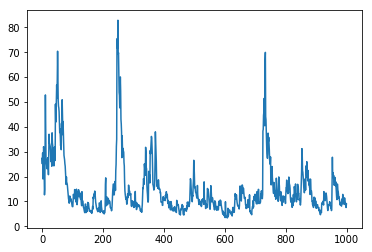

In [21]:
plt.plot(generated_data['condition_nums'])

In [24]:
if False:
    for j in range(10):
        plt.figure(j)
        plt.plot([a_list[i][j] for i in range(1000)])

In [18]:
returns = np.vstack(generated_data['return_vecs'])
cond_nums = generated_data['condition_nums']

In [91]:
class DataGenerator(object):
    """Acts as data provider for each new episode."""
    
    step = 0
    
    # def __init__(self, history, abbreviation, steps=730, window_length=50, start_idx=0, start_date=None):
    def __init__(self, parameters=parameters, steps=730, window_length=50, start_idx=0):
        """
        New Args:
            parameters: dictionary of mgarch parameters from R
            steps: the total number of steps to simulate, default is 2 years
            window_length: observation window, must be less than 50

        Old Args:
            history: (num_stocks, timestamp, 5) open, high, low, close, volume
            abbreviation: a list of length num_stocks with assets name
            steps: the total number of steps to simulate, default is 2 years
            window_length: observation window, must be less than 50
            start_date: the date to start. Default is None and random pick one.
                        It should be a string e.g. '2012-08-13'
        """
        # assert history.shape[0] == len(abbreviation), 'Number of stock is not consistent'
        import copy

        self.parameters = parameters
        self.steps = steps + 1
        self.window_length = window_length
        # self.start_idx = start_idx
        # self.start_date = start_date

        # make immutable class
        # self._data = history.copy()  # all data
        # self.asset_names = copy.copy(abbreviation)

        # NEW
        self._data = self.generate_data()
        
        print('Data generated')
        # get data for this episode, each episode might be different. you can change start date for each episode
        # if self.start_date is None:
        #     self.idx = np.random.randint(low=self.window_length, high=self._data.shape[1] - self.steps)
        # else:
        #     # compute index corresponding to start_date for repeatable sequence
        #     self.idx = date_to_index(self.start_date) - self.start_idx
        #     assert self.idx >= self.window_length and self.idx <= self._data.shape[1] - self.steps, \
        #         'Invalid start date, must be window_length day after start date and simulation steps day before end date'
        # print('Start date: {}'.format(index_to_date(self.idx)))

    def _step(self):
        # get observation matrix from history, exclude volume, maybe volume is useful as it
        # indicates how market total investment changes. Normalize could be critical here
        self.step += 1
        # data in shape [num_assets, num_days, 4]
        # last dim = [open, condition_num,condition_num, close]

        obs = self._data[:, self.step:self.step + self.window_length, :].copy()
        # normalize obs with open price

        # used for compute optimal action and sanity check
        ground_truth_obs = self._data[:, self.step + self.window_length:self.step + self.window_length + 1, :].copy()

        done = self.step >= self.steps
        return obs, done, ground_truth_obs

    def reset(self):
        self.step = 0

        # get data for this episode, each episode might be different.
        if self.start_date is None:
            self.idx = np.random.randint(
                low=self.window_length, high=self._data.shape[1] - self.steps)
        else:
            # compute index corresponding to start_date for repeatable sequence
            self.idx = date_to_index(self.start_date) - self.start_idx
            assert self.idx >= self.window_length and self.idx <= self._data.shape[1] - self.steps, \
                'Invalid start date, must be window_length day after start date and simulation steps day before end date'
        # print('Start date: {}'.format(index_to_date(self.idx)))
        data = self._data[:, self.idx - self.window_length:self.idx + self.steps + 1, :4]
        # apply augmentation?
        self.data = data
        return self.data[:, self.step:self.step + self.window_length, :].copy(), \
               self.data[:, self.step + self.window_length:self.step + self.window_length + 1, :].copy()

    
    def generate_data(self):

        T = self.steps
        Q_bar = self.parameters['Q_bar']
        Q = self.parameters['Q']
        num_assets = self.parameters['num_assets']
        e = self.parameters['e']

        condNum_list = []
        a_list = []

        # initialize
        a0 = np.linalg.cholesky(H_init)@np.random.multivariate_normal(np.zeros(num_assets),1*np.identity(num_assets))

        # needed to ensure H psd
        h0 = np.ones(num_assets)*e
        Q = pd.read_csv('Q_init.csv').drop('Unnamed: 0',axis=1).to_numpy()

        for t in range(T):
            # compute R_t
            Q_star_inv = np.linalg.inv(np.diag(Q.diagonal()))

            R = Q_star_inv@Q_bar@Q_star_inv

            # compute D_t
            h1 = omega + alpha*a0**2 + beta*h0
            D = np.power(np.diag(h1),1/2)
            
            # compute H
            H = D@R@D

            # draw z
            z = np.random.multivariate_normal(np.zeros(num_assets),1*np.identity(num_assets))

            # compute a: a = 𝐻^1/2 @ z
            a1 = np.linalg.cholesky(H)@z
            
            # draw e
            e = np.random.multivariate_normal(np.zeros(num_assets),R)
            
            # step Q
            Q = (1-a-b)*Q_bar + a*np.outer(e,e) + b*Q
            
            # step a,h
            h0 = h1
            a0 = a1.squeeze()
            
            # covariance matrices - keep track of our generated data
            condNum_list.append(np.linalg.cond(H))
            # returns
            a_list.append(a0)
            
        return np.concatenate((np.vstack(a_list),np.asarray(condNum_list)[:,None]),axis=1)

In [92]:
data_gen = DataGenerator()

Data generated
